## Rover Project Test Notebook
**Run the next cell to get code highlighting in the markdown cells.**

In [108]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [109]:
%matplotlib inline
# Importing the needed packages
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob  # For reading in a list of images from a folder


## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

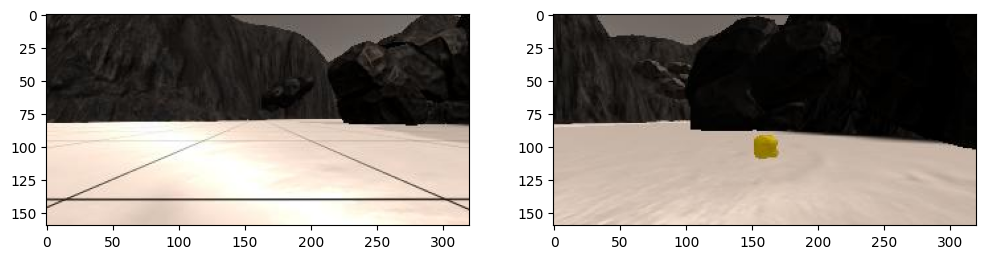

In [110]:
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
# %matplotlib qt # this line is used to turn on the interactive plot mode
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)
# %matplotlib inline # this line is used to turn off the interactive plot mode

## Perspective Transform

In [111]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped

## Color Thresholding

In [112]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def obstacle_thresh(img, rgb_thresh=(160, 160, 160)):
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] <= rgb_thresh[0]) \
                & (img[:,:,1] <= rgb_thresh[1]) \
                & (img[:,:,2] <= rgb_thresh[2])
    color_select[above_thresh] = 1
    return color_select

# Using the interactive tool, R is 120 to 200, G is 100 to 190, and B is 0 to 50
def rock_thresh(img, lower_thresh=(120, 100, 0), upper_thresh=(200, 190, 50)):
    color_select = np.zeros_like(img[:,:,0])
    within_thresh = (img[:,:,0] <= upper_thresh[0]) \
                & (img[:,:,1] <= upper_thresh[1]) \
                & (img[:,:,2] <= upper_thresh[2]) \
                & (img[:,:,0] >= lower_thresh[0]) \
                & (img[:,:,1] >= lower_thresh[1]) \
                & (img[:,:,2] >= lower_thresh[2])
    color_select[within_thresh] = 1
    return color_select

## Coordinate Transformations

In [113]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0])
    y_pixel = -(xpos - binary_img.shape[1]/2 )
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

## Read in saved data and ground truth map of the world
The next cell is all setup to read our recorded data into a `pandas` dataframe.  Here, we also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  

In [114]:
import pandas as pd

df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0))

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3))
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

In [115]:

data = Databucket()
def process_image(img):
    
    # Define calibration box in source (actual) and destination (desired) coordinates
    # I've used the example grid image above to choose source points for the
    # grid cell in front of the rover (each grid cell is 1 square meter in the sim)
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    # The destination box will be 2*dst_size on each side
    dst_size = 5 
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                      [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                      ])
    
    # Apply perspective transform
    warped = perspect_transform(img, source, destination)
    # Apply color threshold to identify navigable terrain/obstacles/rock samples
    colored = color_thresh(warped)
    obstacles = obstacle_thresh(warped)
    rock = rock_thresh(warped)
    # Convert thresholded image pixel values to rover-centric coords
    xpix, ypix = rover_coords(colored)
    xpix_obs, ypix_obs = rover_coords(obstacles)
    xpix_rock, ypix_rock = rover_coords(rock)
    # Convert rover-centric pixel values to world coords
    world_size = 200
    scale = 10
    x_world, y_world = pix_to_world(xpix, ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], world_size, scale)
    x_world_obs, y_world_obs = pix_to_world(xpix_obs, ypix_obs, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], world_size, scale)
    x_world_rock, y_world_rock = pix_to_world(xpix_rock, ypix_rock, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], world_size, scale)
    # Update worldmap
    data.worldmap[y_world, x_world, 1] += 1
    data.worldmap[y_world_obs, x_world_obs, 2] += 1
    data.worldmap[y_world_rock, x_world_rock, 0] += 1

    # Make a mosaic image
    # First create a blank image (can be whatever shape)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    output_image[0:img.shape[0], img.shape[1]:] = warped 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = data.worldmap
    
    # Keep track of the index in the Databucket()
    if data.count < len(data.images) - 1:
        data.count += 1 
    
    return output_image


## Make a video from processed image data

In [118]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
CPU times: total: 8.95 s
Wall time: 10.2 s


### This next cell should function as an inline video player

In [119]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))